Procesando video: C:/Users/Usuario/Documents/TESIS- DE INVESTIGACION/Video.mp4
Los resultados se guardarán en: C:/Users/Usuario/Documents/facial_expression_detector/data/output
Solapamiento entre frente_cejas y ojos: 8 puntos
Solapamiento entre frente_cejas y nariz: 1 puntos
Solapamiento entre frente_cejas y mejillas: 5 puntos
Solapamiento entre frente_cejas y boca: 6 puntos
Solapamiento entre frente_cejas y mandibula: 4 puntos
Solapamiento entre frente_cejas y arrugas: 6 puntos
Solapamiento entre ojos y frente_cejas: 8 puntos
Solapamiento entre ojos y nariz: 2 puntos
Solapamiento entre ojos y boca: 5 puntos
Solapamiento entre nariz y frente_cejas: 1 puntos
Solapamiento entre nariz y ojos: 2 puntos
Solapamiento entre nariz y mejillas: 7 puntos
Solapamiento entre nariz y boca: 1 puntos
Solapamiento entre nariz y mandibula: 21 puntos
Solapamiento entre nariz y arrugas: 11 puntos
Solapamiento entre mejillas y frente_cejas: 5 puntos
Solapamiento entre mejillas y nariz: 7 puntos
Solapamient

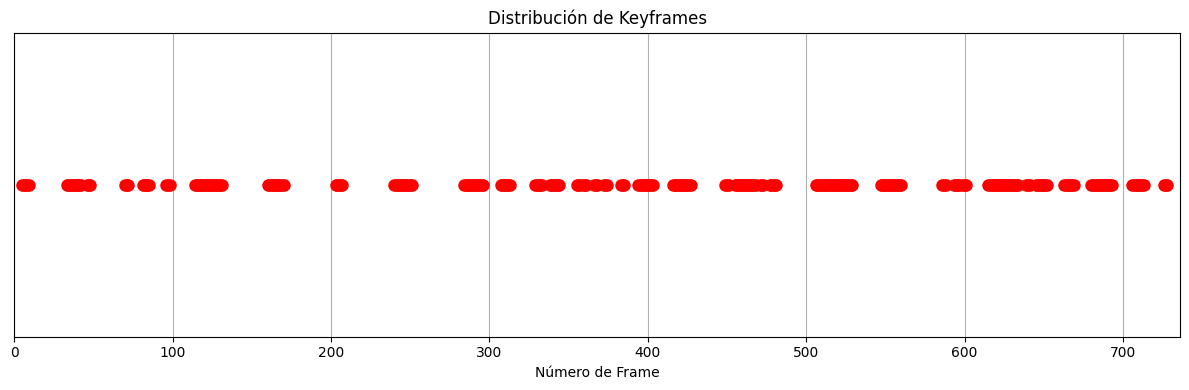

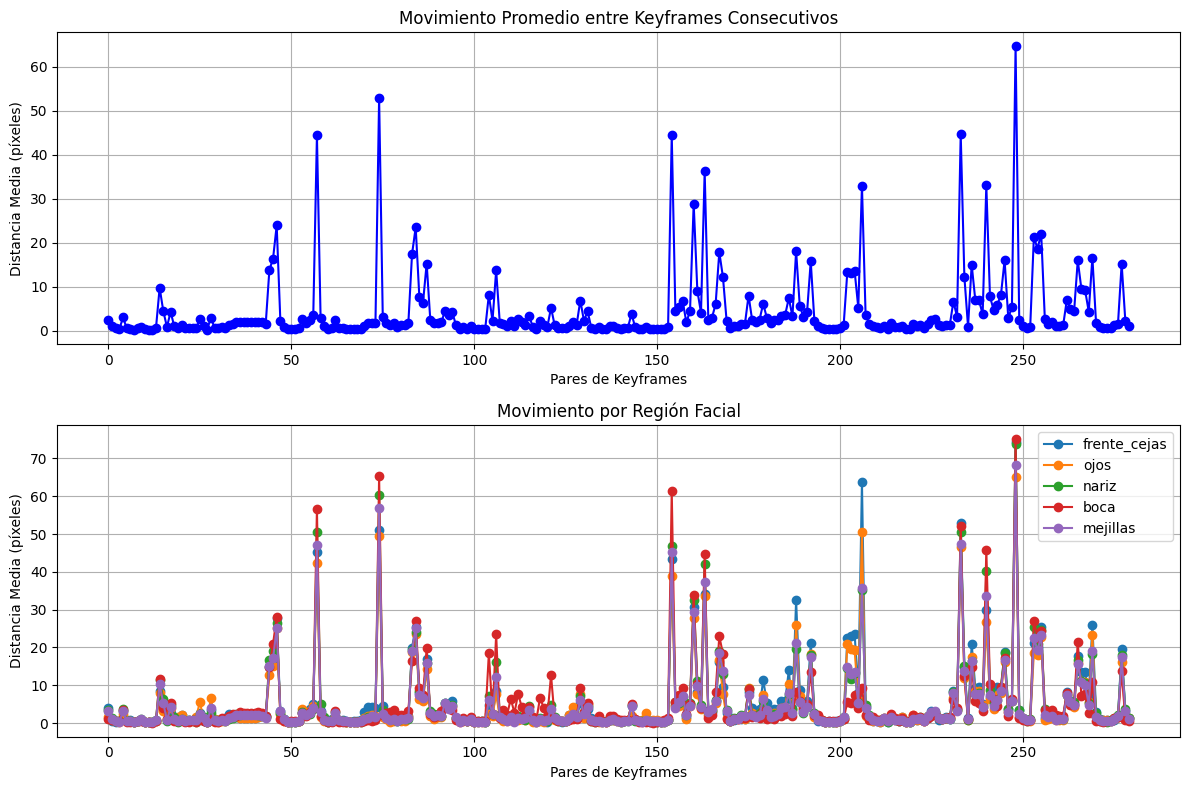

In [1]:

# Importar todos los módulos necesarios
%run 01_constante.ipynb
%run 02_landmarks.ipynb
%run 03_optical_flow.ipynb
%run 04_keyframe.ipynb
%run 05_texture_generator.ipynb
%run 06_video_processor.ipynb
%run 07_result_analyzer.ipynb

def main(video_path, output_folder="output_keyframes", display=True, use_texture_maps=True):
    """
    Función principal que ejecuta todo el pipeline de detección de micro-expresiones
    
    Args:
        video_path: Ruta al video a procesar
        output_folder: Carpeta donde guardar resultados
        display: Si True, muestra visualización
        use_texture_maps: Si True, genera mapas de textura para mejorar el resumen
    
    Returns:
        Dependiendo del valor de use_texture_maps:
        - Si False: Tupla (keyframes, keyframe_indices)
        - Si True: Tupla (keyframes, keyframe_indices, texture_maps)
    """
    print(f"Procesando video: {video_path}")
    print(f"Los resultados se guardarán en: {output_folder}")
    
    # Inicializar componentes
    processor = VideoProcessor()
    
    # Procesar video (con o sin mapas de textura según el parámetro)
    if use_texture_maps:
        print("Usando mapas de textura para mejorar la detección y visualización...")
        result = processor.process_video(video_path, output_folder, display, use_texture_maps)
        keyframes, keyframe_indices, texture_maps = result
    else:
        result = processor.process_video(video_path, output_folder, display)
        keyframes, keyframe_indices = result
        texture_maps = {}
    
    if not keyframes:
        print("No se detectaron keyframes")
        return result
    
    # Mostrar estadísticas
    print(f"\nEstadísticas:")
    print(f"- Total de keyframes detectados: {len(keyframes)}")
    if len(keyframe_indices) > 1:
        gaps = np.diff(keyframe_indices)
        print(f"- Distancia promedio entre keyframes: {np.mean(gaps):.2f} frames")
        print(f"- Distancia mínima entre keyframes: {np.min(gaps)} frames")
        print(f"- Distancia máxima entre keyframes: {np.max(gaps)} frames")
    
    # Si se usaron mapas de textura, mostrar información adicional
    if use_texture_maps and texture_maps:
        print(f"- Mapas de textura generados: {', '.join(texture_maps.keys())}")
    
    # Análisis adicional si se dispone de un analizador
    try:
        analyzer = ResultAnalyzer()
        
        # Analizar movimiento en keyframes
        movement_data = analyzer.analyze_movement_patterns(keyframes, processor.landmarks_detector)
        
        # Visualizar resultados
        if display and keyframe_indices:
            # Obtener total de frames del video
            cap = cv2.VideoCapture(video_path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            cap.release()
            
            # Mostrar distribución de keyframes
            plt_dist = analyzer.visualize_keyframe_distribution(keyframe_indices, total_frames)
            plt_dist.savefig(f"{output_folder}/keyframe_distribution.png")
            
            # Mostrar análisis de movimiento
            if movement_data:
                plt_movement = analyzer.plot_movement_analysis(movement_data)
                plt_movement.savefig(f"{output_folder}/movement_analysis.png")
            
            print(f"\nGráficos de análisis guardados en {output_folder}")
    except Exception as e:
        print(f"No se pudo realizar análisis avanzado: {str(e)}")
    
    return result

# Ejemplo de uso
if __name__ == "__main__":
    video_path = "C:/Users/Usuario/Documents/TESIS- DE INVESTIGACION/Video.mp4"
    output_dir = "C:/Users/Usuario/Documents/facial_expression_detector/data/output"
    # Procesamiento básico (sin mapas de textura)
    # main(video_path)
    
    # O procesamiento avanzado con mapas de textura
    main(video_path, output_folder=output_dir, use_texture_maps=True)
